In [24]:
import google.colab.drive
google.colab.drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [25]:
import numpy as np
import torch
import glob
import os
import datetime
import json
import sys
import yaml
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from PIL import Image
import io

### input information and params ###
"""
dataset_path (mandatory):
Path to a folder including input images.
Images are either as a single multipage tiff file or serial numbered image files, with either of the following format.
".bmp", ".dib", ".pbm", ".pgm", ".ppm", ".pnm", ".ras", ".png", ".tiff", ".tif", ".jp2", ".jpeg", ".jpg", ".jpe"
ALL RESULTS ARE SAVED in dataset_path.

functions_path (mandatory):
Path to functions.py file, which is essential.

local_time_difference:
Time difference relative to UTC (hours). Affects time stamps used in result file names.

start_T, end_T(int, > 0):
You can set frames which are applied to WormTracer.
If you want to use all frames, set both start_T and end_T as 0.

rescale(float, > 0, < 1):
You can change the scale of image to use for tracing by this value.
If MEMORY ERROR occurs, set this value lower.
For example if you set it 0.5, the size of images will be half of the original.
Default value is 1.

Tscale(int, > 0):
You can reduce frames by thinning out the movie by this value.
If MEMORY ERROR occurs, set this value higher.
For example, if you set it to 2, even-numbered frames will be picked up.
This parameter is useful in case frame rate is too high.
Default value is 1.

continuity_loss_weight(float, > 0):
This value is the weight of the continuity constraint.
Around 10000 is recommended, but if the object moves fast, set it lower.

smoothness_loss_weight(float, > 0):
This value is the weight of the smoothness constraint.
Around 50000 is recommended, but if the object bends sharply, set it lower.

length_loss_weight(float, > 0):
This value is the weight of the length continuity constraint.
Around 50 is recommended, but if length of the object changes drastically, set it lower.

center_loss_weight(float, > 0):
This value is the weight of the center position constraint.
Around 50 is recommended.

plot_n(int, > 1):
This value is plot number of center line.
Around 100 is recommended.

epoch_plus(int, > 0):
This value is additional training epoch number.
After annealing is finished, training will be performed for at most epoch_plus times.
Over 1000 is recommended.

speed(float, > 0):
This value is speed of annealing progress.
The larger this value, the faster the learning is completed.
0.1 is efficient, 0.05 is cautious.

lr(float, > 0):
This value is learning rate of training.
Around 0.05 is recommended.

body_ratio(float, > 0):
This value is body (rigid part of the object) ratio of the object.
If the object is a typical worm, set it around 90.

judge_head_method (string, 'amplitude' or 'frequency'):
Discriminate head and tail by eigher of the following criteria,
Variance of body curvature is larger near the head ('amplitude')
Frequency of body curvature change is larger near the head ('frequency')

num_t(int, > 0):
This value means the number of images which are displayed
when show_image function is called.
Default value is 5.
If you want to see all frames, set it to "np.inf".

ShowProgress (True or False):
If True, shows progress during optimization repeats.

SaveProgress (True or False):
If True, saves worm images during optimization in "progress_image" folder created in datafolder.

show_progress_freq(int, > 0):
This value is epoch frequency of displaying tracing progress.

save_progress_freq(int, > 0):
This value is epoch frequency of saving tracing progress.

save_progress_num(int, > 0):
This value is the number of images that are included in saved progress tracing.

SaveCenterlinedWormsSerial (True or False):
If True, saves input images with estimated centerline as seirial numbered png files in full_line_images folder.

SaveCenterlinedWormsMovie (True or False):
If True, saves input images with estimated centerline as a movie full_line_images.mp4

SaveCenterlinedWormsMultitiff (True or False):
If True, saves input images with estimated centerline as a multipage tiff full_line_images.tif

"""

#dataset_path = "/content/gdrive/MyDrive/WormTracer/WP"
dataset_path = "/content/gdrive/MyDrive/iino/WormTracer/WT19_1/004Trim"
functions_path = "/content/gdrive/MyDrive/iino/WormTracer/WT19_1"
local_time_difference = 9

params = {}

# parameters
params['start_T'] = 0
params['end_T'] = 0
params['rescale'] = 1
params['Tscale'] = 2

params['continuity_loss_weight'] = 10000
params['smoothness_loss_weight'] = 100000
params['length_loss_weight'] = 50
params['center_loss_weight'] = 50

params['plot_n'] = 100
params['epoch_plus'] = 1500
params['speed'] = 0.05
params['lr'] = 0.05
params['body_ratio'] = 90
#params['judge_head_method'] = 'amplitude'
params['judge_head_method'] = 'frequency'

params['local_time_difference'] = local_time_difference

# display options
params['num_t'] = 5
params['ShowProgress'] = True #False
params['SaveProgress'] = True #False
params['show_progress_freq'] = 200
params['save_progress_freq'] = 50
params['save_progress_num'] = 50

params['SaveCenterlinedWormsSerial'] = True
params['SaveCenterlinedWormsMovie'] = True
params['SaveCenterlinedWormsMultitiff'] = True

# log
time_now = datetime.datetime.now()
logs = [f"Code executed at {time_now}\n"]
logs.append(f"Params : {params}\n")

#### make use of GPU ####
if torch.cuda.is_available():
  device = 'cuda'
  print('Running using GPU.')
  logs.append("Running using GPU.\n\n")
else:
  device = 'cpu'
  print('Running using CPU. GPU is recommended')
  logs.append("Running using CPU. GPU is recommended\n\n")

Running using GPU.


In [26]:
sys.path.append(functions_path)
from functions import *

# read data property(image size, frame number)
filenames_all = get_filenames(dataset_path)
filenames_full = filenames_all[:params['end_T']][params['start_T']:] if params['end_T'] else filenames_all[params['start_T']:]
filenames = filenames_full[::params['Tscale']]
imshape, Worm_is_black, multi_flag = get_property(filenames, params['rescale'])

# read images and get information
# getting xy plots by thinning in function ; read_image_and_xy()
real_image, x, y, y_st, x_st, unitLength, pre_width = read_image_and_xy(imshape, filenames, params['rescale'], params['plot_n'], Worm_is_black, multi_flag)
theta = make_theta_from_xy(x, y)
print('\rframe = ', len(filenames),' shape = ', real_image.shape, " unitLength = ", unitLength)

# log
time_now = datetime.datetime.now()
logs.append(f"Reading images finished at {time_now}\n")
logs.append(f"frame = {len(filenames)} shape = {real_image.shape} unitLength = {unitLength}\n\n")

We found several extensions available in openCV.
In this case, we loaded a .png file, but if you want to load a file with a different extension, delete the unrelated file.
frame =  10  shape =  (10, 153, 212)  unitLength =  2.8332665379559105


All frames seem to be simple; easy to skeltnize.


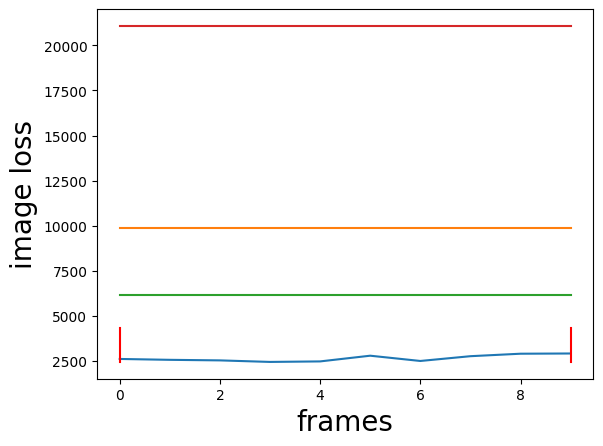

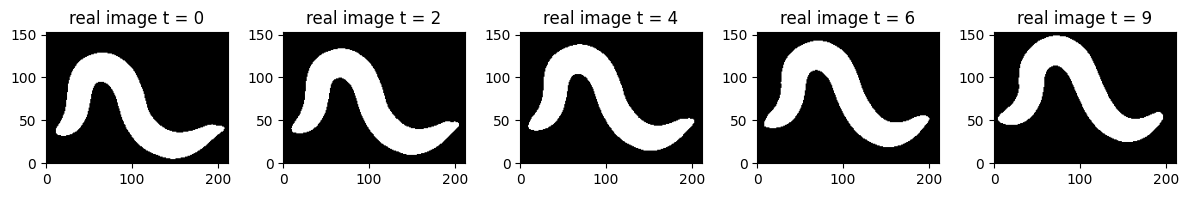

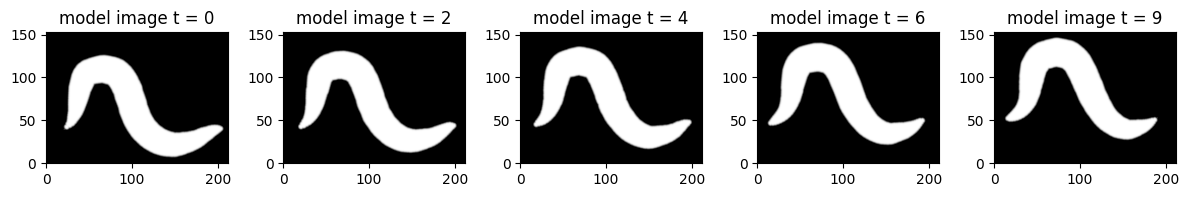

use_points 
 [0 9]


In [27]:
# make worm model image from plots
params['alpha'] = pre_width.min()
image_info = {'image_shape':real_image.shape, 'device':device}
cap_span = calc_cap_span(image_info, params['plot_n'], s_m=8000)
model_image = make_image(x, y, x_st, y_st, params, image_info, cap_span)

# get points for trace blocks
image_losses = np.mean((model_image - real_image)**2, axis=(1,2))
image_loss_max = get_image_loss_max(image_losses, real_image, x, y, x_st, y_st, params, image_info, cap_span)
use_points, nont_flag, simple_area = get_use_points(image_losses, image_loss_max, cap_span, x, y, params['plot_n'], show_plot=True)

show_image(real_image, params['num_t'], title='real image')
show_image(model_image, params['num_t'], title='model image')
print('use_points \n',use_points)

# log 3
time_now = datetime.datetime.now()
logs.append(f"Determining time blocks finished at {time_now}\n")
logs.append(f"use_points : {use_points}\n\n")

(0, 9)


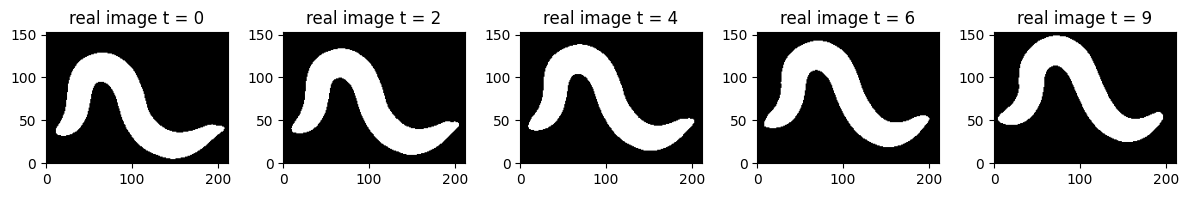

4920.24 366.47 4924.48 0.00 0.00


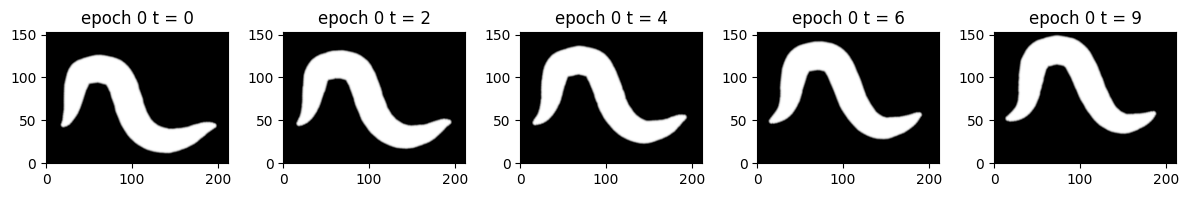

1421.72 14.95 501.35 0.26 440.14


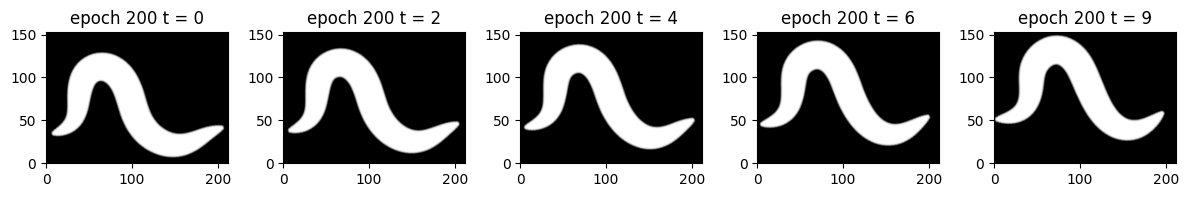

Early stopping at epoch +139.
Minor adjustment done.
970.92 15.93 450.90 7.85


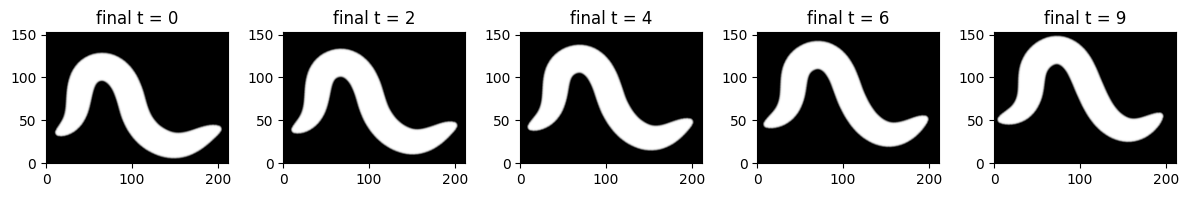

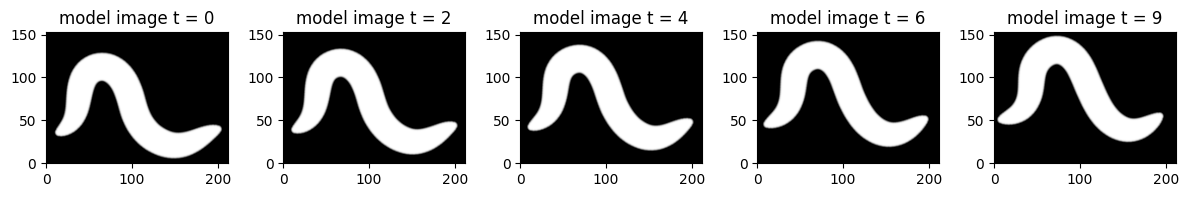

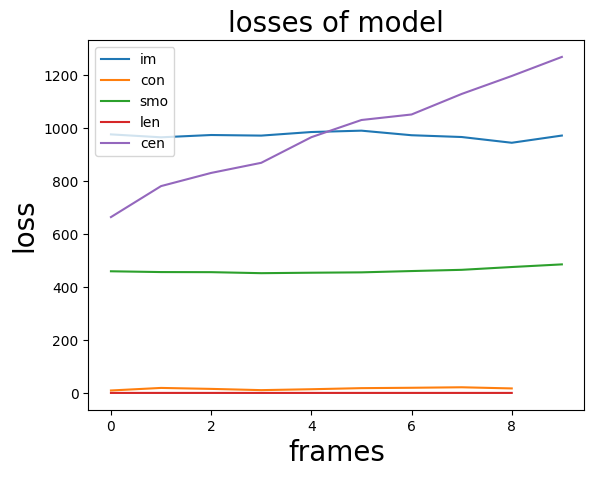

In [28]:
losses_all = []; shape_params = [];
unitLength = prepare_for_train(pre_width, simple_area, x, y, params)
if params['SaveProgress']:
  clear_dir(dataset_path, 'progress_image')
logs.append("STEP1 : optimization for simple posture blocks\n\n")

# main loop 1
for i in range(len(use_points)-1):
  if nont_flag[i]:
    losses_all.append(0)
    continue
  use_area = (use_points[i], use_points[i+1])
  print(use_area); params['use_area'] = use_area
  filenames_ = filenames[use_area[0]:use_area[1]+1]
  T = use_area[1] - use_area[0] + 1
  theta_ = theta[use_area[0]:use_area[1]+1,:].copy()

  # read and preprocess images
  real_image, y_st, x_st = read_image(imshape, filenames_, params['rescale'], Worm_is_black)
  show_image(real_image, params['num_t'], title='real image')
  save_progress(real_image, dataset_path, params, txt='real')
  image_info['image_shape'] = real_image.shape

  # set init value
  theta_cand, _ = make_thetaCand(theta_)
  theta_[-1,:] = theta_cand[0]
  init_cx, init_cy = set_init_xy(real_image)
  init_theta = torch.tensor(theta_)
  init_unitLength = torch.ones(T, dtype=torch.float)*unitLength
  init_data = [init_cx, init_cy, unitLength]

  # make model instance and training
  model = Model(init_cx, init_cy, init_theta, init_unitLength, image_info, params).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
  params['id'] = 0
  losses = train3(model, real_image, optimizer, params, device, init_data, dataset_path, is_nont=False)

  # get trace information
  losses_all.append(losses)
  theta_model = model.theta.detach().cpu().numpy()
  unitL_model = model.unitLength.detach().cpu().numpy().reshape(-1,1)
  x_cent, y_cent = model.cx.detach().cpu().numpy(), model.cy.detach().cpu().numpy()
  shape_params.append((T, model.alpha.detach().cpu(), model.gamma.detach().cpu(), model.delta.detach().cpu()))
  model_image = model()
  show_image(model_image, params['num_t'], title='model image')
  show_loss_plot(losses_all[-1], title='losses of model')

  # reconstruct plots from model results
  x_model, y_model = make_plot(theta_model, unitL_model, x_cent, y_cent)
  x[use_area[0]:use_area[1]+1,:] = x_model + x_st
  y[use_area[0]:use_area[1]+1,:] = y_model + y_st

  # log
  logs.append(str(use_area)+"\n")
  logs.append(f"image loss : {np.mean(losses[0])}\n")
  logs.append(f"continuity loss : {np.mean(losses[1])}\n")
  logs.append(f"smoothing loss : {np.mean(losses[2])}\n")
  logs.append(f"length loss : {np.mean(losses[3])}\n")
  logs.append(f"center loss : {np.mean(losses[4])}\n\n")
time_now = datetime.datetime.now()
logs.append(f"STEP1 finished at {time_now}\n\n")

In [29]:
params['init_alpha'], params['init_gamma'], params['init_delta'] = get_shape_params(shape_params, params)
logs.append("STEP2 : optimization for complex posture blocks\n\n")

# main loop 2
for i in range(len(use_points)-1):
  if not nont_flag[i]:
    continue
  use_area = (use_points[i], use_points[i+1])
  print(use_area); params['use_area'] = use_area
  filenames_ = filenames[use_area[0]:use_area[1]+1]
  T = use_area[1] - use_area[0] + 1
  theta_ = theta[use_area[0]:use_area[1]+1,:].copy()

  # read and preprocess images
  real_image, y_st, x_st = read_image(imshape, filenames_, params['rescale'], Worm_is_black)
  show_image(real_image, params['num_t'], title='real image')
  save_progress(real_image, dataset_path, params, txt='real')
  image_info['image_shape'] = real_image.shape

  # make flipping theta candidate
  theta_cand, _ = make_thetaCand(theta_)

  # set init value
  init_cx, init_cy = set_init_xy(real_image)
  init_theta = torch.from_numpy(np.linspace(theta_[0,:], theta_cand[0], T))
  init_unitLength = torch.ones(T, dtype=torch.float)*unitLength
  init_data = [init_cx, init_cy, unitLength]

  # make model instance and training
  model = Model(init_cx, init_cy, init_theta, init_unitLength, image_info, params).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
  params['id'] = 0
  losses_all[i] = train3(model, real_image, optimizer, params, device, init_data, dataset_path)

  # get trace information
  theta_model = model.theta.detach().cpu().numpy()
  unitL_model = model.unitLength.detach().cpu().numpy().reshape(-1,1)
  x_cent, y_cent = model.cx.detach().cpu().numpy(), model.cy.detach().cpu().numpy()
  model_image = model()

  # flip final theta to trace again
  init_theta = torch.from_numpy(np.linspace(theta_[0,:], theta_cand[1], T))

  # make model instance and training
  model = Model(init_cx, init_cy, init_theta, init_unitLength, image_info, params).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
  params['id'] = 1
  losses = train3(model, real_image, optimizer, params, device, init_data, dataset_path)

  # get trace information if loss is smaller
  select_ind = loss_compair([losses_all[i], losses])
  if select_ind:
    theta_model = model.theta.detach().cpu().numpy()
    unitL_model = model.unitLength.detach().cpu().numpy().reshape(-1,1)
    x_cent, y_cent = model.cx.detach().cpu().numpy(), model.cy.detach().cpu().numpy()
    model_image = model()
    losses_all[i] = losses
  remove_progress(dataset_path, '{}-{}_id{}*.png'.format(use_area[0], use_area[1], 1-select_ind))

  # reconstruct plots from model results
  x_model, y_model = make_plot(theta_model, unitL_model, x_cent, y_cent)
  show_image(model_image, params['num_t'], title='model image')
  show_loss_plot(losses_all[i], title='losses of model{}'.format(select_ind))
  x[use_area[0]:use_area[1]+1,:] = x_model + x_st
  y[use_area[0]:use_area[1]+1,:] = y_model + y_st

  # log
  logs.append(str(use_area)+"\n")
  logs.append(f"image loss : {np.mean(losses[0])}\n")
  logs.append(f"continuity loss : {np.mean(losses[1])}\n")
  logs.append(f"smoothing loss : {np.mean(losses[2])}\n")
  logs.append(f"length loss : {np.mean(losses[3])}\n")
  logs.append(f"center loss : {np.mean(losses[4])}\n\n")

time_now = datetime.datetime.now()
logs.append(f"STEP2 finished at {time_now}\n\n")

In [30]:
# revise areas which have too large loss
losslarge_area = find_losslarge_area(losses_all)
logs.append("STEP3 :　re-optimization for unsuccessful blocks with complex postures\n\n")

for i in range(len(use_points)-1):
  if losslarge_area[i] and nont_flag[i]:
    use_area = (use_points[i], use_points[i+1])
    print(use_area[0], ":", use_area[1], " too large loss! ")
    params['use_area'] = use_area
    filenames_ = filenames[use_area[0]:use_area[1]+1]
    T = use_area[1] - use_area[0] + 1
    theta_ = theta[use_area[0]:use_area[1]+1,:].copy()

    # read and preprocess images
    real_image, y_st, x_st = read_image(imshape, filenames_, params['rescale'], Worm_is_black)
    show_image(real_image, params['num_t'], title='real image')
    image_info['image_shape'] = real_image.shape

    # make flipping candidate
    _, theta_cand = make_thetaCand(theta_)

    # set init value
    init_cx, init_cy = set_init_xy(real_image)
    init_theta = torch.from_numpy(np.linspace(theta_[0,:], theta_cand[0], T))
    init_unitLength = torch.ones(T, dtype=torch.float)*unitLength
    init_data = [init_cx, init_cy, unitLength]

    # make model instance and training
    update = 0
    model = Model(init_cx, init_cy, init_theta, init_unitLength, image_info, params).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    params['id'] = 2
    losses = train3(model, real_image, optimizer, params, device, init_data, dataset_path)

    # get trace information if loss is smaller
    if loss_compair([losses_all[i], losses]):
      print("update")
      update = 2
      theta_model = model.theta.detach().cpu().numpy()
      unitL_model = model.unitLength.detach().cpu().numpy().reshape(-1,1)
      x_cent, y_cent = model.cx.detach().cpu().numpy(), model.cy.detach().cpu().numpy()
      model_image = model()
      losses_all[i] = losses
      remove_progress(dataset_path, '{}-{}_id[0-1]*.png'.format(use_area[0], use_area[1]))
    else:
      print("no update")
      remove_progress(dataset_path, '{}-{}_id2*.png'.format(use_area[0], use_area[1]))

    # flip final theta and trace again
    init_theta = torch.from_numpy(np.linspace(theta_[0,:], theta_cand[1], T))

    # make model instance and training
    model = Model(init_cx, init_cy, init_theta, init_unitLength, image_info, params).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    params['id'] = 3
    losses = train3(model, real_image, optimizer, params, device, init_data, dataset_path)

    # get trace information if loss is smaller
    if loss_compair([losses_all[i], losses]):
      print("update")
      update = 3
      theta_model = model.theta.detach().cpu().numpy()
      unitL_model = model.unitLength.detach().cpu().numpy().reshape(-1,1)
      x_cent, y_cent = model.cx.detach().cpu().numpy(), model.cy.detach().cpu().numpy()
      model_image = model()
      losses_all[i] = losses
      remove_progress(dataset_path, '{}-{}_id[0-2]*.png'.format(use_area[0], use_area[1]))
    else:
      print("no update")
      remove_progress(dataset_path, '{}-{}_id3*.png'.format(use_area[0], use_area[1]))

    if update:
      x_model, y_model = make_plot(theta_model, unitL_model, x_cent, y_cent)
      show_image(model_image, params['num_t'], title='model image')
      show_loss_plot(losses_all[i], title='losses of new model')

      # reconstruct plots from model results
      x[use_area[0]:use_area[1]+1,:] = x_model + x_st
      y[use_area[0]:use_area[1]+1,:] = y_model + y_st

      # log
      logs.append(str(use_area)+" updated\n")
      logs.append(f"image loss : {np.mean(losses_all[i][0])}\n")
      logs.append(f"continuity loss : {np.mean(losses_all[i][1])}\n")
      logs.append(f"smoothing loss : {np.mean(losses_all[i][2])}\n")
      logs.append(f"length loss : {np.mean(losses_all[i][3])}\n")
      logs.append(f"center loss : {np.mean(losses_all[i][4])}\n\n")

time_now = datetime.datetime.now()
logs.append(f"STEP3 finished at {time_now}\n\n")

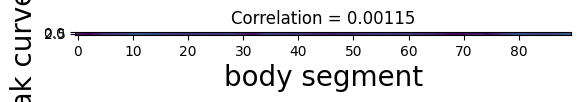

In [31]:
# save params and plots
params_for_save = params.copy()
for key, value in params_for_save.items():
  if torch.is_tensor(value):
    params_for_save[key] = params_for_save[key].item()
del params_for_save['use_area']

# check flipping
x, y = flip_check(x, y)

# check which side is head or tail
if not 'judge_head_method' in params.keys() or params['judge_head_method'] == 'amplitude':
    x, y, x_rev, y_rev = judge_head_amplitude(x, y)
elif params['judge_head_method'] == 'frequency':
    x, y, x_rev, y_rev = judge_head_frequency(x, y)

# cancel reduction
T_read_all = params['end_T'] - params['start_T'] if params['end_T'] else len(filenames_all) - params['start_T']
x, y = cancel_reduction(x, y, T_read_all, len(filenames), params['plot_n'])
x_rev, y_rev = cancel_reduction(x_rev, y_rev, T_read_all, len(filenames), params['plot_n'])

tz = datetime.timezone(datetime.timedelta(hours=params['local_time_difference']))
time_now = datetime.datetime.now(tz).strftime('%Y-%m-%d_%H:%M:%S.%f')
if not os.path.isdir(os.path.join(dataset_path, 'results')):
  os.mkdir(os.path.join(dataset_path, 'results'))
with open(os.path.join(dataset_path, 'results', '{}_params.json'.format(time_now)), "w") as f:
  json.dump(params_for_save, f)
with open(os.path.join(dataset_path, 'results', '{}_params.yaml'.format(time_now)), "w") as f:
    yaml.safe_dump(params_for_save, f, sort_keys=False)
np.savetxt(os.path.join(dataset_path, 'results', '{}_x.csv'.format(time_now)), x/params['rescale'], delimiter=',')
np.savetxt(os.path.join(dataset_path, 'results', '{}_y.csv'.format(time_now)), y/params['rescale'], delimiter=',')
np.savetxt(os.path.join(dataset_path, 'results', '{}_x_rev.csv'.format(time_now)), x_rev/params['rescale'], delimiter=',')
np.savetxt(os.path.join(dataset_path, 'results', '{}_y_rev.csv'.format(time_now)), y_rev/params['rescale'], delimiter=',')
logs.append("Params and plots are successfully saved.\n\n")

# save log
if not os.path.isdir(os.path.join(dataset_path, 'logs')):
  os.mkdir(os.path.join(dataset_path, 'logs'))
with open(os.path.join(dataset_path, 'logs', f'{time_now}_log.txt'), mode='w') as f:
  for log in logs:
    f.write(log)

In [32]:
# save full of real_image and centerline as png images
real_image, y_st, x_st = read_image(imshape, filenames_full, params['rescale'], Worm_is_black)

if params['SaveCenterlinedWormsSerial']:
    clear_dir(dataset_path, 'full_line_image')
    for t in range(len(filenames_full)):
        filename = os.path.join(dataset_path, 'full_line_image', 'full_line_image'+str(t).zfill(len(str(len(filenames_full))))+'.png')
        plt.imshow(real_image[t], cmap='gray')
        plt.plot(x[t]-x_st, y[t]-y_st, c="r", lw=3)
        plt.savefig(filename)
        plt.close()
    print('\npng images saved to ' + filename + ' etc.')


png images saved to /content/gdrive/MyDrive/iino/WormTracer/WT19_1/004Trim/full_line_image/full_line_image19.png etc.


In [33]:
# save full of real_image and centerline as mp4 movie
if params['SaveCenterlinedWormsMovie']:
    fig, ax = plt.subplots(figsize=(4, 4))
    ims = []
    for t in range(len(filenames_full)):
        if t%100==0:
            print(t, end=' ')
        lines = []
        lines.extend(ax.plot(x[t]-x_st, y[t]-y_st, c="r", lw=3))
        lines.extend([ax.imshow(real_image[t], cmap='gray')])
        title = ax.text(0.5, 1.01, 'index: '+str(t), ha='center', va='bottom', transform=ax.transAxes, fontsize='large', color='black')
        ims.append(lines+[title])
    ani = animation.ArtistAnimation(fig, ims, interval=50)
    rc('animation', html='jshtml')
    plt.close()
    ################# ani
    filename = os.path.join(dataset_path, 'full_line_images.mp4')
    ani.save(filename)
    print('\nMovie saved to '+ filename)

0 
Movie saved to /content/gdrive/MyDrive/iino/WormTracer/WT19_1/004Trim/full_line_images.mp4


In [34]:
# save full of real_image and centerline as multipage tiff
if params['SaveCenterlinedWormsMultitiff']:
    filename = os.path.join(dataset_path, 'full_line_images.tif')
    stack = []
    fig, ax = plt.subplots(figsize=(3, 3))
    for t in range(len(filenames_full)):
        if t%100==0:
            print(t, end=' ')
        ax.imshow(real_image[t], cmap='gray')
        ax.plot(x[t]-x_st, y[t]-y_st, c="r", lw=3)
        plt.title('index: '+str(t))
        buf = io.BytesIO()
        fig.savefig(buf, format="png")
        plt.cla()
        buf.seek(0)
        img2=Image.open(buf).convert('RGB')
        stack.append(img2)
    stack[0].save(filename, compression="tiff_deflate", save_all=True, append_images=stack[1:])
    plt.close(fig)
    print('\nMultipage tiff saved to '+ filename)

0 
Multipage tiff saved to /content/gdrive/MyDrive/iino/WormTracer/WT19_1/004Trim/full_line_images.tif
